Linear Regression has the following assumptions:
-  Linear relationship
-  Multivariate normality
-  No or little multicollinearity
-  No auto-correlation
-  Homoscedasticity (all variables have same variance)

Multivariate normality means that regression requires all its variables to be normal. By having skewed data we violate the assumption of normality.

The violations can impact regression in the following ways:
Disproportionate influence on parameter estimates: Parameter estimation is based on the minimization of squared error. observations in skewed data will make a disproportionate effect on the parameter estimates. 
Due to the skewness of data Confidence Intervals (statistics) can be either too wide or too narrow as they are based on the assumption of normally distributed errors.

The assumption of normal distribution is not needed if we are assuming that the equation derived is correct and get the predictions to reduce the RMS.
But if we want to make inferences about the model and also estimate whether a given prediction error will exceed a threshold or not we require the assumptions.

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns




# import some modules from scipy for the calculation of skew, normality and pearsons R value

from scipy import stats
from scipy.stats import skew, norm
from scipy.stats.stats import pearsonr

sns.set(style='whitegrid', rc={"grid.linewidth": 0.1})
sns.set_context("paper", font_scale=1.5)

%matplotlib inline

In [129]:
train = pd.read_csv('/Users/constar/Documents/GitHub/Data_Science_Portfolio/House_Price_Regression_Kaggle/train.csv')
test = pd.read_csv('/Users/constar/Documents/GitHub/Data_Science_Portfolio/House_Price_Regression_Kaggle/test.csv')

# Exploratory Data Analysis

In [130]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [131]:
train.shape

(1460, 81)

In [132]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [133]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [134]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


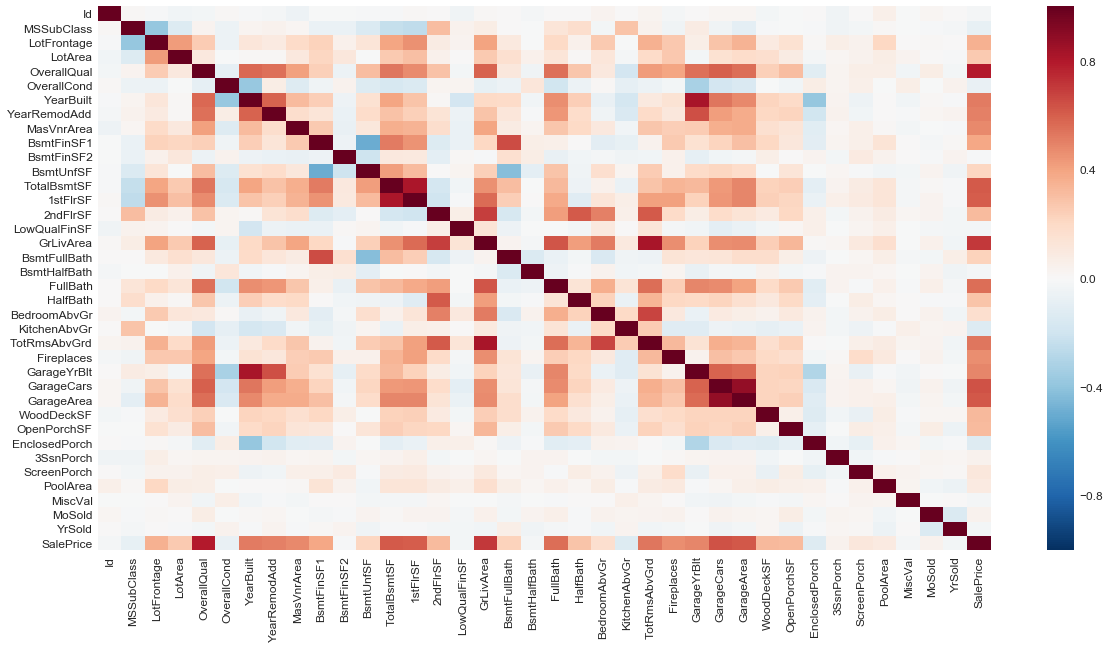

In [135]:
# large feature spaces with lots of positive correlation with the target variable (sale price) 
# and multi-colinearity between features
plt.subplots(figsize=(20,10))
corr = train.corr()
sns.heatmap(corr, cmap = 'RdBu_r', center = 0)

In [136]:

w, v = np.linalg.eig(corr)

In [137]:
w

array([  7.97867896e+00,   3.21555239e+00,   2.64737113e+00,
         2.02785094e+00,   1.49141809e+00,  -6.30707814e-05,
        -3.06381929e-07,   9.38855868e-02,   1.09234219e-01,
         1.34020592e-01,   1.48573802e-01,   1.94341990e-01,
         1.90672182e-01,   2.60703166e-01,   2.89032329e-01,
         3.20436289e-01,   3.73361429e-01,   4.04423120e-01,
         4.94400157e-01,   5.84426384e-01,   6.15829712e-01,
         1.19647659e+00,   6.77088330e-01,   1.15411570e+00,
         1.12809885e+00,   1.13521299e+00,   1.09688040e+00,
         1.07068491e+00,   1.05047718e+00,   7.34204125e-01,
         1.01639888e+00,   9.99595260e-01,   9.58184736e-01,
         7.91672477e-01,   8.08725253e-01,   8.27837599e-01,
         9.08679700e-01,   8.71517930e-01])

In [138]:
v

array([[ -2.96284114e-03,   1.72994224e-02,   7.62901122e-04, ...,
          3.18734581e-01,  -4.71610180e-02,   3.29156660e-01],
       [ -1.88658109e-02,   1.59377078e-01,  -2.33874654e-01, ...,
         -6.66485883e-02,  -1.78645011e-01,   4.59712916e-02],
       [  1.63205324e-01,  -9.22915683e-05,   3.01537503e-01, ...,
         -1.36216138e-01,   1.00141253e-01,  -1.01163031e-01],
       ..., 
       [  2.02249145e-02,   2.92274863e-02,  -5.38258712e-03, ...,
         -2.10327570e-01,  -4.39097355e-02,   1.57553286e-01],
       [ -1.22380377e-02,  -3.63743471e-02,   3.18201956e-03, ...,
         -1.12680989e-01,  -1.08000465e-01,   5.97064544e-03],
       [  3.14857811e-01,  -2.22739576e-02,   2.59119070e-02, ...,
          1.58511548e-02,  -3.12394164e-03,   3.76481960e-02]])

In [139]:
# combine all data into one data from

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],test.loc[:,'MSSubClass':'SaleCondition']))

# all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
#                       test.loc[:,'MSSubClass':'SaleCondition']))

In [140]:
all_data.shape

(2919, 79)

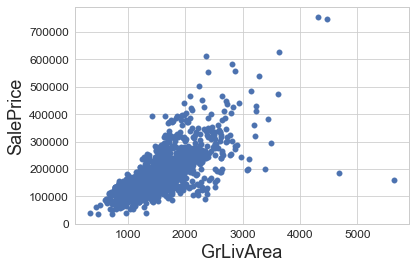

In [141]:
# outliers are reported in the supporting documentation for the dataset, for the sale price and GrLivArea (sq.footage)

fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize = 18)
plt.xlabel('GrLivArea', fontsize = 18)


In [142]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

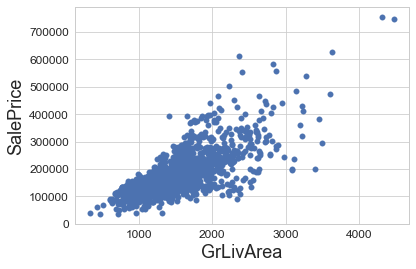

In [143]:
# outliers eliminated

fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize = 18)
plt.xlabel('GrLivArea', fontsize = 18)

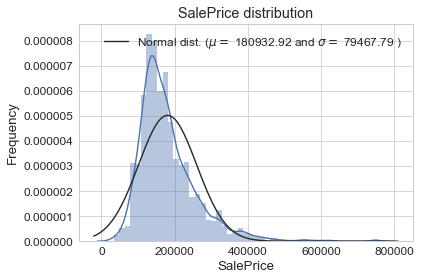

In [144]:
# check the distribution of the target variable Sale Price

sns.distplot(train.SalePrice, fit = norm);

# store the norm fit parameters

(mu, sigma) = norm.fit(train['SalePrice'])

# labelling


plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

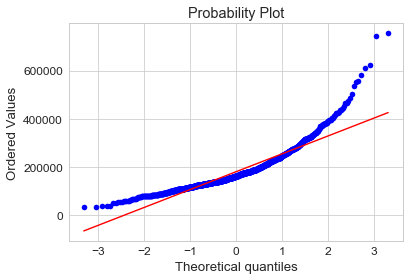

In [145]:
# probability distribution plot for sale price target label
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

In [146]:
# So the target variable is not normally distributed.
# To fit linear models we must first log transform the data.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e789518>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11e7c04a8>]], dtype=object)

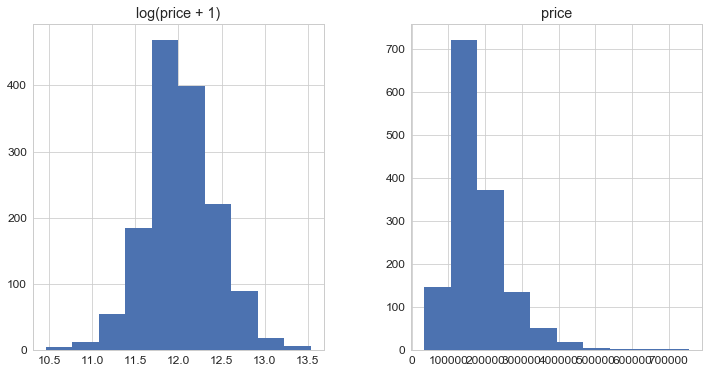

In [147]:
# log transform render non-normally distributed features normally distributed

matplotlib.rcParams['figure.figsize'] = (12,6)
prices = pd.DataFrame({'price':train['SalePrice'], 'log(price + 1)':np.log1p(train['SalePrice'])})
prices.hist()

In [148]:
# log transform skewed features

#log transform the target:

train['SalePrice'] = np.log1p(train['SalePrice'])

# log transform the skewed numeric features
numeric_features = all_data.dtypes[all_data.dtypes !='object'].index

skewed_features = train[numeric_features].apply(lambda x: skew(x.dropna()))
# apply a skew cut-off
skewed_features = skewed_features[skewed_features > 0.75]
skewed_features = skewed_features.index

all_data[skewed_features] = np.log1p(all_data[skewed_features])


 mu = 12.02 and sigma = 0.40



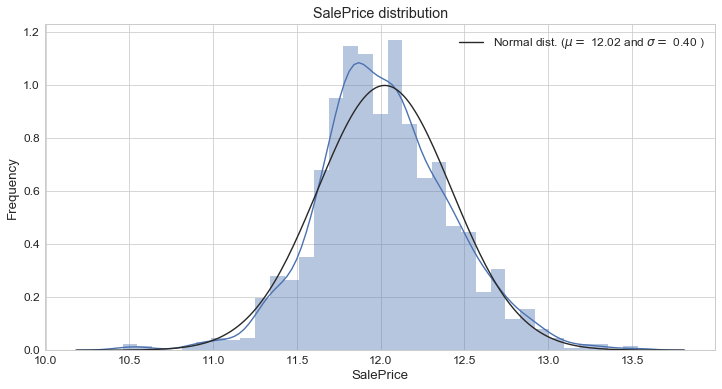

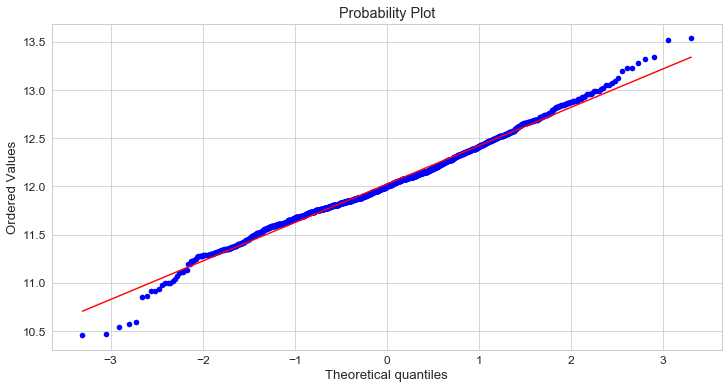

In [149]:
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot quantile quantile plot anothe test of normality
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

In [150]:
# # get dummies for the categorical features
# all_data = pd.get_dummies(all_data)

# # fill na values with the mean values for the column

# all_data = all_data.fillna(all_data.mean())
# train = train.fillna(train.mean())
# test = test.fillna(test.mean())

In [151]:
# preparing data for sklearn

# X_train = all_data[:train.shape[0]]
# X_test = all_data[train.shape[0]:]



In [152]:
# ntrain = train.shape[0]
# ntest = test.shape[0]

In [153]:
# y_train = train.SalePrice
# train = all_data[:ntrain]
# test = all_data[ntrain:]

# y_train = train.SalePrice

In [154]:
# X_train.describe()

In [155]:
ntrain = train.shape[0] # ndarray.shape[0] is the number of rows ndarray.shape[1] is the number of columns
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 80)


In [156]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageQual,5.450806
GarageCond,5.450806
GarageFinish,5.450806
GarageYrBlt,5.450806


In [157]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

all_data["Alley"] = all_data["Alley"].fillna("None")

all_data["Fence"] = all_data["Fence"].fillna("None")

all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()
                                                         
                                                         
                                                    

,Missing Ratio


In [158]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [159]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 79)


In [160]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [161]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


In [162]:
 train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

In [163]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 60 skewed numerical features to Box Cox transform


In [164]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 221)


In [165]:
train = all_data[:ntrain]
test = all_data[ntrain:]

# Base Models

In [166]:
# Linear regression using Lasso (L1-norm), ElasticNet and Ridge regression (L2-norm) methods 

from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

import lightgbm as lgb

In [167]:
# specifying cross validation folds including shuffling (stratification necessary also?)

n_folds = 5

def rmsle_cv(model):
    KF = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, train.values, y_train, scoring = 'neg_mean_squared_error', cv = KF))
    return(rmse)

# n_folds = 5

# def rmsle_cv(model):
#     kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
#     rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
#     return(rmse)

In [168]:
# Lasso regression sensitive to outliers. L1-norm regularisation
# sklearn Robustscaler() method on the Lasso pipeline helps.

lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.0005, random_state=1))

In [169]:
# Elastic net is a ratio of L1 and L2 norm regularisation

elastic = make_pipeline(RobustScaler(), ElasticNet(alpha = 0.0005, l1_ratio = .9, random_state = 3))

In [170]:
# Kernel ridge not plain old ridge

kernelridge = KernelRidge(alpha = 0.6, kernel = 'polynomial', degree = 2, coef0 = 2.5)

In [171]:
# Gradient boosting regressor

gboost = GradientBoostingRegressor(n_estimators=3000, learning_rate = 0.05,
                                  max_depth = 4, max_features = 'sqrt',
                                  min_samples_leaf = 15, min_samples_split = 10,
                                  loss='huber', random_state = 5)

In [172]:
# xgboost the king. Parameters found by Bayesian grid search

xgb_model = xgb.XGBRegressor(colsample_bytree=0.4603, gamma = 0.0468,
                            learning_rate = 0.05, max_depth = 3,
                            min_child_weight = 1.7817, n_estimators = 2200,
                            reg_alpha = 0.4640, reg_lambda = 0.8571,
                            subsample = 0.5213, silent = 1,
                            random_state = 7, nthread = -1)

In [173]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [174]:
# assess the performance of the regressors using the root mean square logarithmic error

score = rmsle_cv(lasso)
print('\nLasso score : {:.4f} ({:.4f}) \n'.format(score.mean(), score.std()))

score = rmsle_cv(elastic)
print('ElasticNet score: {:.4f} ({:4f}) \n'.format(score.mean(), score.std()))

score = rmsle_cv(kernelridge)
print('Kernel Ridge score: {:.4f} ({:4f}) \n'.format(score.mean(), score.std()))

score = rmsle_cv(gboost)
print('Gradient Boosting score: {:.4f} ({:4f}) \n'.format(score.mean(), score.std()))

score = rmsle_cv(xgb_model)
print('XGBoost score: {:.4f} ({:4f}) \n'.format(score.mean(), score.std()))

score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


Lasso score : 0.1115 (0.0074) 

ElasticNet score: 0.1116 (0.007416) 

Kernel Ridge score: 0.1163 (0.006461) 

Gradient Boosting score: 0.1161 (0.008750) 

XGBoost score: 0.1149 (0.005412) 

LGBM score: 0.1142 (0.0072)



# Stacking

In [175]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [176]:
# simplest approach to stacking is to average the base models

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
#         define clones of the original models to use in the stacked averaging
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
#         train cloned base models
        for model in self.models_:
            model.fit(X, y)
            
        return self
    
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])

        return np.mean(predictions, axis = 1)

In [177]:
# average a few base models

averaged_models = AveragingModels(models = (elastic,gboost, kernelridge, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1088 (0.0077)



In [178]:
# Adding a meta-model for a more sophisticated stacking

class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds = 5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        
# fit data on clones of the original models
    
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits = self.n_folds, shuffle=True, random_state=156)
        
# train cloned based models and make out of fold (oob) predictions
# needed for the training of the cloned meta-model

        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i , model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
# train the cloned meta-model using out of fold predictions as a new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
    
#Do the predictions of all base models on the test data and use the averaged predictions as 
#     #meta-features for the final prediction which is done by the meta-model

    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis = 1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [179]:
stacked_averaged_models = StackingAveragedModels(base_models = (elastic, gboost, kernelridge), meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1083 (0.0069)


In [180]:
# final training and prediction

stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

# stacked_averaged_models.fit(train.values, y_train)
# stacked_train_pred = stacked_averaged_models.predict(train.values)
# stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
# print(rmsle(y_train, stacked_train_pred))

0.0804820054034


In [181]:
xgb_model.fit(train, y_train)
xgb_train_pred = xgb_model.predict(train)
xgb_pred = np.expm1(xgb_model.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.077873849784


In [182]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.0711989590016


In [183]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

In [184]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)

In [185]:
# import pandas as pd
# import numpy as np
# from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
# from sklearn.linear_model import ElasticNet, Lasso
# from sklearn.feature_selection import SelectFromModel
# from sklearn.svm import SVR
# from sklearn.model_selection import KFold, cross_val_score
# from sklearn.pipeline import make_pipeline
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import RobustScaler
# from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
# import xgboost as xgb

# train = pd.read_csv('../input/train.csv')
# test = pd.read_csv('../input/test.csv')

# y_train = train['y'].values
# y_mean = np.mean(y_train)
# id_test = test['ID']

# num_train = len(train)
# df_all = pd.concat([train, test])
# df_all.drop(['ID', 'y'], axis=1, inplace=True)

# df_all = pd.get_dummies(df_all, drop_first=True)

# train = df_all[:num_train]
# test = df_all[num_train:]

# class StackingCVRegressorAveraged(BaseEstimator, RegressorMixin, TransformerMixin):
#     def __init__(self, regressors, meta_regressor, n_folds=5):
#         self.regressors = regressors
#         self.meta_regressor = meta_regressor
#         self.n_folds = n_folds

#     def fit(self, X, y):
#         self.regr_ = [list() for x in self.regressors]
#         self.meta_regr_ = clone(self.meta_regressor)

#         kfold = KFold(n_splits=self.n_folds, shuffle=True)

#         out_of_fold_predictions = np.zeros((X.shape[0], len(self.regressors)))

#         for i, clf in enumerate(self.regressors):
#             for train_idx, holdout_idx in kfold.split(X, y):
#                 instance = clone(clf)
#                 self.regr_[i].append(instance)

#                 instance.fit(X[train_idx], y[train_idx])
#                 y_pred = instance.predict(X[holdout_idx])
#                 out_of_fold_predictions[holdout_idx, i] = y_pred

#         self.meta_regr_.fit(out_of_fold_predictions, y)

#         return self

#     def predict(self, X):
#         meta_features = np.column_stack([
#             np.column_stack([r.predict(X) for r in regrs]).mean(axis=1)
#             for regrs in self.regr_
#         ])
#         return self.meta_regr_.predict(meta_features)
        

# class StackingCVRegressorRetrained(BaseEstimator, RegressorMixin, TransformerMixin):
#     def __init__(self, regressors, meta_regressor, n_folds=5, use_features_in_secondary=False):
#         self.regressors = regressors
#         self.meta_regressor = meta_regressor
#         self.n_folds = n_folds
#         self.use_features_in_secondary = use_features_in_secondary

#     def fit(self, X, y):
#         self.regr_ = [clone(x) for x in self.regressors]
#         self.meta_regr_ = clone(self.meta_regressor)

#         kfold = KFold(n_splits=self.n_folds, shuffle=True)

#         out_of_fold_predictions = np.zeros((X.shape[0], len(self.regressors)))

#         # Create out-of-fold predictions for training meta-model
#         for i, regr in enumerate(self.regr_):
#             for train_idx, holdout_idx in kfold.split(X, y):
#                 instance = clone(regr)
#                 instance.fit(X[train_idx], y[train_idx])
#                 out_of_fold_predictions[holdout_idx, i] = instance.predict(X[holdout_idx])

#         # Train meta-model
#         if self.use_features_in_secondary:
#             self.meta_regr_.fit(np.hstack((X, out_of_fold_predictions)), y)
#         else:
#             self.meta_regr_.fit(out_of_fold_predictions, y)
        
#         # Retrain base models on all data
#         for regr in self.regr_:
#             regr.fit(X, y)

#         return self

#     def predict(self, X):
#         meta_features = np.column_stack([
#             regr.predict(X) for regr in self.regr_
#         ])

#         if self.use_features_in_secondary:
#             return self.meta_regr_.predict(np.hstack((X, meta_features)))
#         else:
#             return self.meta_regr_.predict(meta_features)
        
# class AveragingRegressor(BaseEstimator, RegressorMixin, TransformerMixin):
#     def __init__(self, regressors):
#         self.regressors = regressors

#     def fit(self, X, y):
#         self.regr_ = [clone(x) for x in self.regressors]
        
#         # Train base models
#         for regr in self.regr_:
#             regr.fit(X, y)

#         return self

#     def predict(self, X):
#         predictions = np.column_stack([
#             regr.predict(X) for regr in self.regr_
#         ])
#         return np.mean(predictions, axis=1)

# en = make_pipeline(RobustScaler(), SelectFromModel(Lasso(alpha=0.03)), ElasticNet(alpha=0.001, l1_ratio=0.1))
    
# rf = RandomForestRegressor(n_estimators=250, n_jobs=4, min_samples_split=25, min_samples_leaf=25, max_depth=3)
                           
# et = ExtraTreesRegressor(n_estimators=100, n_jobs=4, min_samples_split=25, min_samples_leaf=35, max_features=150)

# xgbm = xgb.sklearn.XGBRegressor(max_depth=4, learning_rate=0.005, subsample=0.9, base_score=y_mean,
#                                 objective='reg:linear', n_estimators=1000)
                           
# stack_avg = StackingCVRegressorAveraged((en, rf, et), ElasticNet(l1_ratio=0.1, alpha=1.4))

# stack_with_feats = StackingCVRegressorRetrained((en, rf, et), xgbm, use_features_in_secondary=True)

# stack_retrain = StackingCVRegressorRetrained((en, rf, et), ElasticNet(l1_ratio=0.1, alpha=1.4))

# averaged = AveragingRegressor((en, rf, et, xgbm))

# results = cross_val_score(en, train.values, y_train, cv=5, scoring='r2')
# print("ElasticNet score: %.4f (%.4f)" % (results.mean(), results.std()))

# results = cross_val_score(rf, train.values, y_train, cv=5, scoring='r2')
# print("RandomForest score: %.4f (%.4f)" % (results.mean(), results.std()))

# results = cross_val_score(et, train.values, y_train, cv=5, scoring='r2')
# print("ExtraTrees score: %.4f (%.4f)" % (results.mean(), results.std()))

# results = cross_val_score(xgbm, train.values, y_train, cv=5, scoring='r2')
# print("XGBoost score: %.4f (%.4f)" % (results.mean(), results.std()))

# results = cross_val_score(averaged, train.values, y_train, cv=5, scoring='r2')
# print("Averaged base models score: %.4f (%.4f)" % (results.mean(), results.std()))

# results = cross_val_score(stack_with_feats, train.values, y_train, cv=5, scoring='r2')
# print("Stacking (with primary feats) score: %.4f (%.4f)" % (results.mean(), results.std()))

# results = cross_val_score(stack_retrain, train.values, y_train, cv=5, scoring='r2')
# print("Stacking (retrained) score: %.4f (%.4f)" % (results.mean(), results.std()))
                 
# results = cross_val_score(stack_avg, train.values, y_train, cv=5, scoring='r2')
# print("Stacking (averaged) score: %.4f (%.4f)" % (results.mean(), results.std()))
